In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['svg.fonttype'] = 'path'
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['savefig.bbox'] = 'tight'

In [2]:
adata = sc.read('../data/results/smart-seq/hvgs.h5ad')

/home/dakota/anaconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/dakota/anaconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


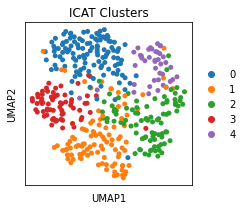

In [3]:

sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
fig, ax = plt.subplots(figsize=(3,3))
sc.pl.umap(adata, color='sslouvain', ax=ax, s=100, save='_icat_clusters.svg', title="ICAT Clusters")


In [4]:
adata.var.Name = adata.var.Name.astype(str)
adata.var.set_index("Name", inplace=True)
adata.var.index = adata.var.index.astype(str)
adata.var_names_make_unique()

In [5]:
adata.var.loc[['PPSC']]

,SPU,UniProt.ID,UniProt.Name,IPR.Desc,IPR.IDs,KEGG.IDs,NCBI.ID,TrEMBL.ID,Length,ncfs_weights,Chlorate_weights,Control_weights,MK886_weights,informative
Name,,,,,,,,,,,,,,
PPSC,SPU_028395,P96202,PPSC_MYCTU,Thioesterase;Acyl transferase domain;Phosphopa...,IPR001031;IPR001227;IPR009081;IPR013968;IPR014...,ava:Ava_4742,NP_001239013.1,356460897.0,7896.0,1.787925,0.239032,0.001254,1.787925,True


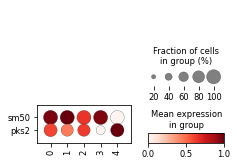

In [6]:
# rename genes follwoing SPU annotations to align with transcriptome + LVAR 3.0
adata.var.rename(index={'PPSC': "pks2", 'SM34': "sm50"}, inplace=True)
sc.pl.dotplot(
    adata,
    var_names=['sm50', 'pks2'],
    groupby='sslouvain',
    standard_scale='var',
    save='_ncfs_markers.svg',
    swap_axes=True,
    cmap='Reds'
)

In [10]:

adata.var['ncfs_rank'] = adata.var.ncfs_weights.rank(ascending=False)
plot_data = adata.var.sort_values('ncfs_rank')
plot_data.query('informative').ncfs_rank.max()

37.0

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


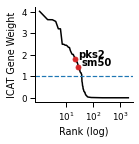

In [35]:
sns.set_context('paper')


# fig, ax = plt.subplots(fi)

adata.var['ncfs_rank'] = adata.var.ncfs_weights.rank(ascending=False)
plot_data = adata.var.sort_values('ncfs_rank')
fig, ax = plt.subplots(figsize=(1.75, 1.75))
selected =  plot_data[plot_data.index.isin(["pks2", "sm50"])]
ax.plot(plot_data.ncfs_rank, plot_data.ncfs_weights, c='black', zorder=0, lw=1.5)
ax.scatter(selected.ncfs_rank, selected.ncfs_weights, c=sns.color_palette()[3], s=25, zorder=1)
ax.set_xscale('log')
ax.axhline(y=1, ls='--')
# ax.axvline(x=plot_data.query('informative').ncfs_rank.max(), ls='--')
ax.set_yticks(range(5))
ax.set_xlabel('Rank (log)')
ax.set_ylabel("ICAT Gene Weight")
sns.despine()
ax.annotate(
    text='sm50',
    xy=plot_data.loc['sm50', ['ncfs_rank', 'ncfs_weights']].values,
    xytext=plot_data.loc['sm50', ['ncfs_rank', 'ncfs_weights']].values + np.array([100, 0.05]),
    horizontalalignment='center',
#     color=params['color'],
    fontsize=10,
    fontweight='bold'
)
ax.annotate(
    text='pks2',
    xy=plot_data.loc['pks2', ['ncfs_rank', 'ncfs_weights']].values,
    xytext=plot_data.loc['pks2', ['ncfs_rank', 'ncfs_weights']].values + np.array([65, 0.09]),
    horizontalalignment='center',
#     color=params['color'],
    fontsize=10,
    fontweight='bold'
)
ax.set_xticks([10, 100, 1000])
# ax.annotate(
#     text=f"x={plot_data.query('informative').ncfs_rank.astype(int).max()}",
#     xy=[75, 3.5]
# )
plt.savefig('figures/sm50_pks2_gene_weights.svg', dpi=200, bbox_inches='tight')

In [115]:
adata.obs.head()

/home/dakota/Code/evaluate-icat/notebooks


In [204]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

def compare_clusters(anno_df, comparisons=None, cluster_col='louvain',
                     compare_col='treatment', merge_cols=None, alpha=0.05):
    """
    Compare cell make-up between identified clusters.
    
    Parameters
    ----------
    anno_df : sc.AnnData
        Annotated dataframe containing cluster membership for each observation
            and a second categorical variable to compare frequency against.
    comparisons : list, optional
        Post-hoc pairwise comparisons to perform. Elements of the list should be
            length 2 containers containing categories to compare (e.g.
            ('Control', 'Expermintanl')). Frequencies between conditions
            will be compared in each cluster using a pairwise G-Test (the
            default is None, which results in no post-hoc analysis). 
    cluster_col : str, optional
        Name of the column in `anno_df.obs` containing observation cluster/group
            assignment (the default is 'louvain'.)
    compare_col : str, optional
        Name of the column in `anno_df.obs` partitioning observations into
            groups of interest (the default is 'treatment', which compares
            distribution of treatments within clusters.)
    merge_cols : dict, optional
        Name of columns to merge together. Keys should point to list of column
            names to merge. The merged column name will be set the key (e.g.
            {'Control': ['ASW', 'DMSO']} will merge 'ASW' and 'DMSO' counts to 
            a single 'Control' column). Default is None, and no merging is
            performed.
    
    Returns
    -------
    dictionary
        Dictionary containing comparison results between clusters including
        G-tests of independence and, if a `comparisons` argument was provided,
        pairwise Fisher exact test results.
        key-value pairs:
            'gtest': dictionary of Gtest results
                key-value pairs:
                    'observed': matrix of observed counts.
                    'expected': matrix of expected counts.
                    'pvals': pvalues for a GTest of independence following
                        index order of 'observed' and 'expected' tables.
                    'pvals.adj': adjusted p-values using the bonferonni
                        correction.
            'fisher': dictionary of pairwise comparison results. Results are
                contained in a dictionary keyed by comparison groups separated
                by a hyphen (e.g. if ['X', 'Y'] was provided as a comparison,
                results of the comparison would be keyed 'X-Y').
                
                key-value pairs:
                    'odds': numpy.array of odds ratios between comparisons
                        ordered by cluster.
                    'pvals': numpy.array of calculated p-values orderd by
                        cluster.
                    'pvals.adj': numpy.array of adjusted p-values by benjamin-hochberg fdr.
                    'cluster': id denoting which cluster comparisons. 
    """
    # check for cluster column
    if cluster_col not in anno_df.obs.columns:
        raise ValueError('No {} column in observation data.'.format(
                         cluster_col))

    # check for comparison column
    if compare_col not in anno_df.obs.columns:
        raise ValueError('No {} column in observations data.'.format(
                         compare_col))
    
    #TODO check for comparisons in comparison column

    count_table = pd.crosstab(anno_df.obs[cluster_col],
                              anno_df.obs[compare_col])
    if merge_cols is not None and isinstance(merge_cols, dict):
        for key, columns in merge_cols.items():
            try:
                count_table[key] = count_table[columns].sum(axis=1)
            except KeyError:
                raise('Unknown columns: {}'.format(columns))
            count_table.drop(columns, axis=1, inplace=True)
        count_table = count_table[sorted(count_table.columns.values)]
        
    
    # calculate probabilities for comparison values
    probabilities = np.sum(count_table, axis=0) / np.sum(count_table.values)

    # calculate total number of cells per cluster in comparison
    group_counts = np.sum(count_table, axis=1)
    
    # matrix multipy cluster counts and condition probabilities to get
    # expected counts
    expectation = group_counts.values.reshape((count_table.shape[0], 1))\
                  @ probabilities.values.reshape((1, count_table.shape[1]))
    expectation = pd.DataFrame(data=expectation, index=count_table.index,
                               columns=count_table.columns)

    # perform tests of independence between treatments and 
    results = stats.power_divergence(count_table, expectation,
                                     axis=1, lambda_='log-likelihood')
    gtest_results = {'cluster': count_table.index.values,
                     'pvals': results.pvalue,
                     'pvals.adj': multipletests(results.pvalue, method='fdr_bh')[1]}
    gtest_results['sig'] = gtest_results['pvals.adj'] < alpha

    out = {'gtest': pd.DataFrame.from_dict(gtest_results)}
    # perform post-hoc pairwise comparisons on significant clusters
    # using odds-ratio/fisher exact tests
    if comparisons is not None and out['gtest'].sig.sum() > 0: 
        fisher_dfs = []
        # retrieve clusters with gtest p.value < alpha
        to_test = out['gtest'].query('sig').cluster.values.astype(
            count_table.index.dtype
        )
        for each in comparisons:
            if len(each) != 2:
                msg = ('Comparisons must be pairwise. Received'
                       ' {} groups: {}'.format(len(each), each))
                raise ValueError(msg)
            
            pairwise = count_table.loc[:, list(each)].copy()
            out_key = '-'.join(each)
            results  = {'odds': np.ones(to_test.shape[0]),
                        'pvals': np.ones(to_test.shape[0]),
                        'pvals.adj': np.ones(to_test.shape[0]),
                        'cluster': to_test,
                        'comparison': [out_key] * to_test.shape[0]}
            for i, cluster in enumerate(to_test):

                # create a 2 x 2 contigency table between treatment comparisons
                # and cluster membership. Counts are pairwise between treatments
                # and cluster X membership vs. not X
                test_cluster = pairwise.loc[cluster, :]
                other_clusters = [x for x in pairwise.index if x != cluster]
                not_cluster = pairwise.loc[other_clusters, :].sum()
                contingency = pd.concat((test_cluster, not_cluster), axis=1)

                # perform fisher exact's test
                odds, pval = stats.fisher_exact(contingency.values)
                results['odds'][i] = odds
                results['pvals'][i] = pval
            fisher_dfs.append(pd.DataFrame.from_dict(results))
        out['fisher'] = pd.concat(fisher_dfs)
        out['fisher']['pvals.adj'] = multipletests(out['fisher']['pvals'], method='fdr_bh')[1]
        out['fisher']['sig'] = out['fisher']['pvals.adj'] < alpha
    return out

dif_abundance = compare_clusters(adata,
                                 comparisons=[['Chlorate', 'Control'],['MK886', 'Control']],
                                 cluster_col='sslouvain',
                                 compare_col='treatment',
                                 merge_cols=None)
dif_abundance['gtest']
# if not os.path.exists('figures')
# dif_abundance['gtest'].to_csv('figures/icat_gtest.csv')

,cluster,pvals,pvals.adj,sig
0,0,2.195669e-01,2.195669e-01,False
1,1,1.212742e-03,2.021236e-03,True
2,2,1.726507e-02,2.158134e-02,True
3,3,4.671642e-11,1.167910e-10,True
4,4,1.085823e-19,5.429114e-19,True


In [205]:
dif_abundance['fisher'].query('sig')

,odds,pvals,pvals.adj,cluster,comparison,sig
0,2.092073,6.391881e-03,1.022701e-02,1,Chlorate-Control,True
2,0.378755,1.029785e-03,2.746094e-03,3,Chlorate-Control,True
1,2.570455,2.892238e-03,5.784475e-03,2,MK886-Control,True
2,0.017763,6.408011e-13,2.563204e-12,3,MK886-Control,True
3,inf,5.184784e-15,4.147827e-14,4,MK886-Control,True


In [206]:
dif_abundance['fisher'].to_csv('figures/icat_fisher.csv')

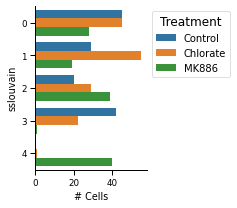

In [132]:
def counts_by_treatment(obs, x, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(2, 3))
    ax = sns.countplot(data=obs, y=x, hue='treatment', hue_order=['Control', 'Chlorate', 'MK886'], ax=ax, 
                       orientation='horizontal')
    ax.legend_.set_bbox_to_anchor((1, 1))
    ax.legend_.set_title('Treatment')
    ax.set_xlabel("# Cells")
    sns.despine()
    return ax
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.title_fontsize'] = 12
counts_by_treatment(adata.obs, 'sslouvain')
ax.set_ylabel("ICAT Cluster")
ax.set_xticks(range(0, 60, 10))
plt.savefig('figures/cell_counts.svg', bbox_inches='tight', dpi=200)

In [208]:
adata.obs.head()

,batch,run.id,timepoint,treatment,louvain,sslouvain
index,,,,,,
ASW_C11_2016_07_29,2016-07-29-1,2016-07-29,18hpf,Control,1,3
Chlorate_C04_2016_07_29,2016-07-29-1,2016-07-29,18hpf,Chlorate,None,3
Chlorate_A10_2016_07_29,2016-07-29-1,2016-07-29,18hpf,Chlorate,None,3
Chlorate_C07_2016_07_29,2016-07-29-1,2016-07-29,18hpf,Chlorate,None,0
ASW_E01_2016_07_29,2016-07-29-1,2016-07-29,18hpf,Control,1,3


In [209]:
seurat = sc.read('../data/results/smart-seq/seurat/adata.h5ad')

seurat.obs.seurat_clusters = pd.Categorical(seurat.obs.seurat_clusters)
seurat.obs['is_4'] = pd.Categorical((seurat.obs.sslouvain == 4).astype(str), ['True', 'False'])
seurat.obs['is_3'] = pd.Categorical((seurat.obs.sslouvain == 3).astype(str), ['True', 'False'])

/home/dakota/anaconda3/envs/single-cell/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/dakota/anaconda3/envs/single-cell/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


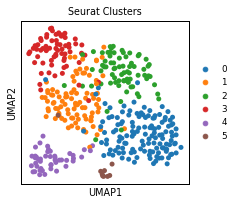

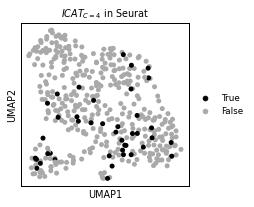

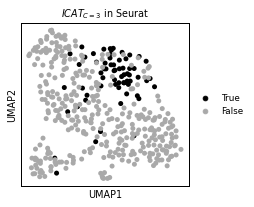

,cluster,pvals,pvals.adj,sig
0,0,0.869398,0.869398,False
1,1,0.770959,0.869398,False
2,2,0.300698,0.869398,False
3,3,0.454597,0.869398,False
4,4,0.253075,0.869398,False
5,5,0.648499,0.869398,False


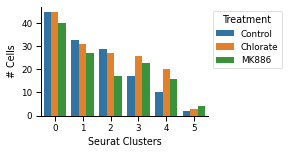

In [210]:
def integration_comparison(dataset, cluster, method, ext='svg'):
    fig, ax = plt.subplots(figsize=(3,3))
    sc.pl.umap(dataset, color=cluster, save=f'_{method}_clusters.{ext}', s=100, ax=ax, title=f"{method} Clusters")
    fig, ax = plt.subplots(figsize=(3,3))
    sc.pl.umap(dataset, color='is_4', palette=['black', 'darkgray'], save=f'_icat_4_in_{method}.{ext}',s=100, ax=ax, title=f'$ICAT_{{C=4}}$ in {method}')
    fig, ax = plt.subplots(figsize=(3,3))
    sc.pl.umap(dataset, color='is_3', palette=['black', 'darkgray'], save=f'_icat_3_in_{method}.{ext}',s=100, ax=ax, title=f'$ICAT_{{C=3}}$ in {method}')
    fig, ax = plt.subplots(figsize=(3, 2))
    ax = counts_by_treatment(dataset.obs, x=cluster, ax=ax)
    ax.set_xlabel(f"{method} Clusters")
    plt.savefig(f'figures/{method}_counts.{ext}', bbox_inches='tight', dpi=200)
    results = compare_clusters(
        dataset,
        comparisons=[['Chlorate', 'Control'],['MK886', 'Control']],
        cluster_col=cluster,
        compare_col='treatment',
        merge_cols=None
    )
    # dif_abundance['fisher'].query('sig')
    results['gtest'].to_csv(f'figures/{method}_gtest.csv')
    try:
        results['fisher'].to_csv(f'figures/{method}_fisher.csv')
    except KeyError:
        pass
    return results
seurat_results = integration_comparison(seurat, 'seurat_clusters', 'Seurat', ext='svg')
seurat_results['gtest']
    

In [211]:
scanorama = sc.read('../data/results/smart-seq/scanorama/adata.h5ad')
scanorama.obs.index = scanorama.obs.apply(lambda x: x.name.split('-')[0], axis=1)
scanorama.obs['is_4'] = pd.Categorical((adata.obs.sslouvain == 4).astype(str), ['True', 'False'])
scanorama.obs['is_3'] = pd.Categorical((adata.obs.sslouvain == 3).astype(str), ['True', 'False'])

/home/dakota/anaconda3/envs/single-cell/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/dakota/anaconda3/envs/single-cell/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


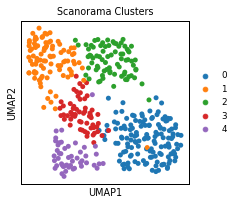

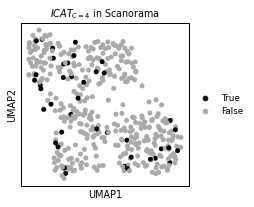

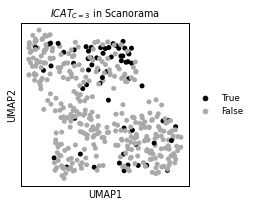

,cluster,pvals,pvals.adj,sig
0,0,0.553182,0.553182,False
1,1,0.100985,0.168308,False
2,2,0.000177,0.000883,True
3,3,0.063621,0.159054,False
4,4,0.323730,0.404662,False


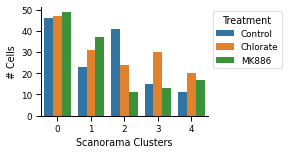

In [212]:
scanorama_results = integration_comparison(scanorama, 'scanorama.louvain', 'Scanorama', 'svg')
scanorama_results['gtest']

In [213]:
scanorama_results['fisher']

,odds,pvals,pvals.adj,cluster,comparison,sig
0,0.434451,0.004597,0.004597,2,Chlorate-Control,True
0,0.219722,0.000011,0.000021,2,MK886-Control,True


In [214]:
adata.obs['scanorama_clusters'] = scanorama.obs['scanorama.louvain']

In [228]:
import os
import itertools
import seaborn as sns
def analyze_cluster_overlap(obs, x, y, xlabel, ylabel, prefix='', ext='svg'):
    overlap = obs.groupby(
        [x, y]
        ).size()\
        .reset_index()\
        .rename(columns={0: 'n_cells'})\
        .pivot_table(index=x, columns=y)
    overlap.columns = overlap.columns.droplevel()
    jaccard_scores = pd.DataFrame(index=overlap.index, columns=overlap.columns, dtype=float)
    for (row, col) in itertools.product(overlap.index, overlap.columns):
        intersection = overlap.at[row, col]
        union = overlap.loc[row, :].sum() + overlap[col].sum() - intersection
        jaccard_scores.at[row, col] = intersection / union
    fig, ax = plt.subplots(figsize=(3, 3))
    overlap_fig = sns.heatmap(
        overlap,
        annot=True,
        annot_kws={'fontsize': 12},
        fmt='0',
        cmap='Greens',
        mask=overlap == 0,
        cbar_kws={'label': '# Cells'},

    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig(os.path.join('figures', prefix + f'overlap.{ext}'))
    # plt.cla()
    # plt.clf()
    plt.show()
    fig, ax = plt.subplots(figsize=(3, 3))
    jaccard_fig = sns.heatmap(
        jaccard_scores,
        annot=True,
        annot_kws={'fontsize': 10},
        fmt='0.2f',
        cmap='Blues',
        mask=jaccard_scores < 0.05,
        cbar_kws={'label': 'Jaccard'},
        vmin=0,
        vmax=1
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig(os.path.join('figures', prefix + f'jaccard.{ext}'))
    return overlap, jaccard_scores, overlap_fig, jaccard_fig

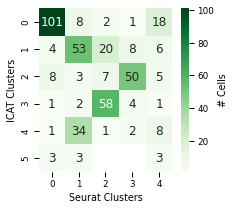

(sslouvain          0   1   2   3   4
 seurat_clusters                     
 0                101   8   2   1  18
 1                  4  53  20   8   6
 2                  8   3   7  50   5
 3                  1   2  58   4   1
 4                  1  34   1   2   8
 5                  3   3   0   0   3,
 sslouvain               0         1         2         3         4
 seurat_clusters                                                  
 0                0.687075  0.035556  0.009259  0.005155  0.117647
 1                0.019512  0.375887  0.125786  0.054054  0.047619
 2                0.043716  0.017341  0.045455  0.568182  0.045872
 3                0.005464  0.011976  0.604167  0.031496  0.009434
 4                0.006135  0.295652  0.007519  0.018349  0.101266
 5                0.024194  0.027523  0.000000  0.000000  0.063830,
 <AxesSubplot:xlabel='Seurat Clusters', ylabel='ICAT Clusters'>,
 <AxesSubplot:xlabel='Seurat Clusters', ylabel='ICAT Clusters'>)

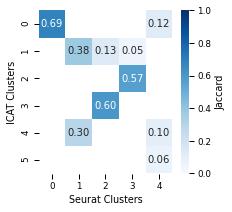

In [229]:
analyze_cluster_overlap(
    seurat.obs,
    'seurat_clusters',
    'sslouvain',
    'Seurat Clusters',
    'ICAT Clusters',
    prefix='icat_vs_seurat_',
    ext='svg'
)

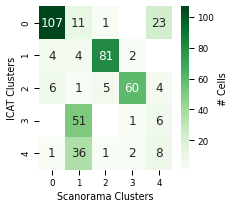

(sslouvain             0   1   2   3   4
 scanorama_clusters                     
 0                   107  11   1   0  23
 1                     4   4  81   2   0
 2                     6   1   5  60   4
 3                     0  51   0   1   6
 4                     1  36   1   2   8,
 sslouvain                  0         1         2         3         4
 scanorama_clusters                                                  
 0                   0.699346  0.047009  0.004367  0.000000  0.143750
 1                   0.019512  0.021053  0.826531  0.012987  0.000000
 2                   0.031915  0.005618  0.031447  0.740741  0.035398
 3                   0.000000  0.463636  0.000000  0.008197  0.064516
 4                   0.006061  0.313043  0.007407  0.018018  0.098765,
 <AxesSubplot:xlabel='Scanorama Clusters', ylabel='ICAT Clusters'>,
 <AxesSubplot:xlabel='Scanorama Clusters', ylabel='ICAT Clusters'>)

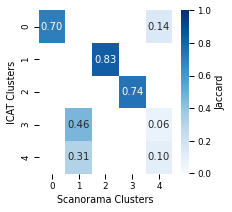

In [230]:
analyze_cluster_overlap(
    adata.obs,
    'scanorama_clusters',
    'sslouvain',
    'Scanorama Clusters',
    'ICAT Clusters',
    prefix='icat_vs_scan_',
    ext='svg'
)